# TCS Stock Data - Live and Latest

This project performs analysis and prediction of TCS stock prices using historical stock data. It includes data preprocessing, exploratory data analysis (EDA), feature engineering, and machine learning models (Linear Regression and LSTM) to forecast future stock prices.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

import pickle
from tqdm import tqdm


ImportError: Traceback (most recent call last):
  File "C:\Users\dell\anaconda3\Lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 73, in <module>
    from tensorflow.python._pywrap_tensorflow_internal import *
ImportError: DLL load failed while importing _pywrap_tensorflow_internal: A dynamic link library (DLL) initialization routine failed.


Failed to load the native TensorFlow runtime.
See https://www.tensorflow.org/install/errors for some common causes and solutions.
If you need help, create an issue at https://github.com/tensorflow/tensorflow/issues and include the entire stack trace above this error message.

In [5]:
# Load dataset (ensure the correct path is used)
df = pd.read_csv('TCS_stock_history.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')
df.head()

NameError: name 'pd' is not defined

In [5]:
# Check for null values and convert types
df[['Open', 'High', 'Low', 'Close']] = df[['Open', 'High', 'Low', 'Close']].apply(pd.to_numeric, errors='coerce')
df.fillna(method='ffill', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4463 entries, 0 to 4462
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          4463 non-null   datetime64[ns]
 1   Open          4463 non-null   float64       
 2   High          4463 non-null   float64       
 3   Low           4463 non-null   float64       
 4   Close         4463 non-null   float64       
 5   Volume        4463 non-null   int64         
 6   Dividends     4463 non-null   float64       
 7   Stock Splits  4463 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 279.1 KB


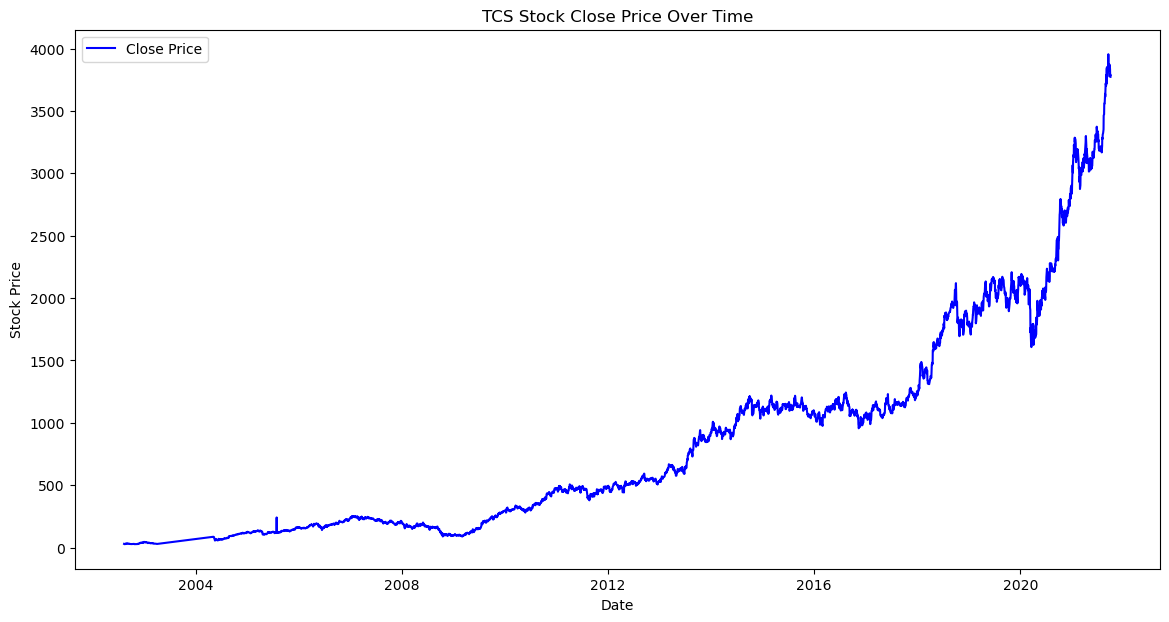

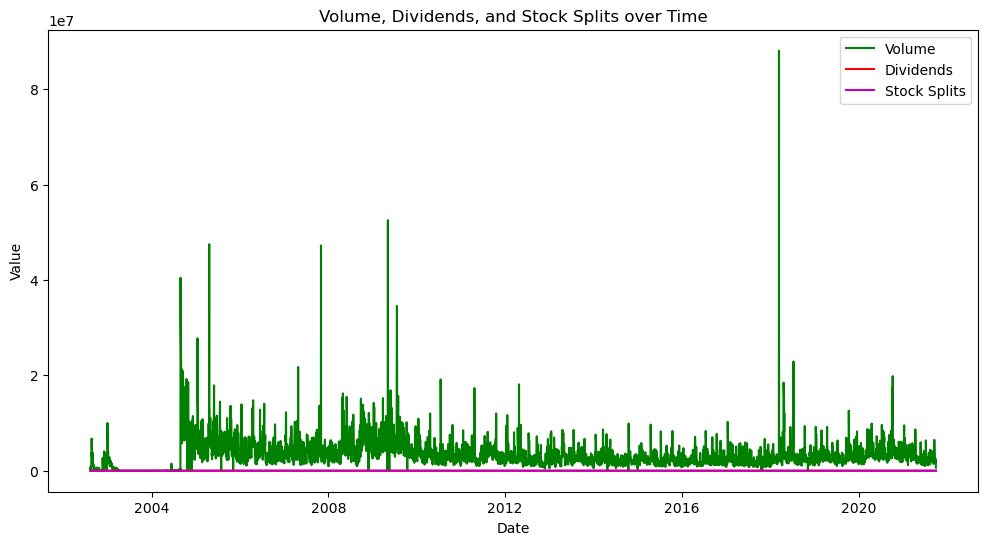

In [7]:
# Plot close price
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Close'], label='Close Price', color='blue')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('TCS Stock Close Price Over Time')
plt.legend()
plt.show()

# Volume, Dividends, and Stock Splits over Time
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Volume'], label='Volume', color='g')
plt.plot(df['Date'], df['Dividends'], label='Dividends', color='r')
plt.plot(df['Date'], df['Stock Splits'], label='Stock Splits', color='m')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Volume, Dividends, and Stock Splits over Time')
plt.legend()
plt.show()

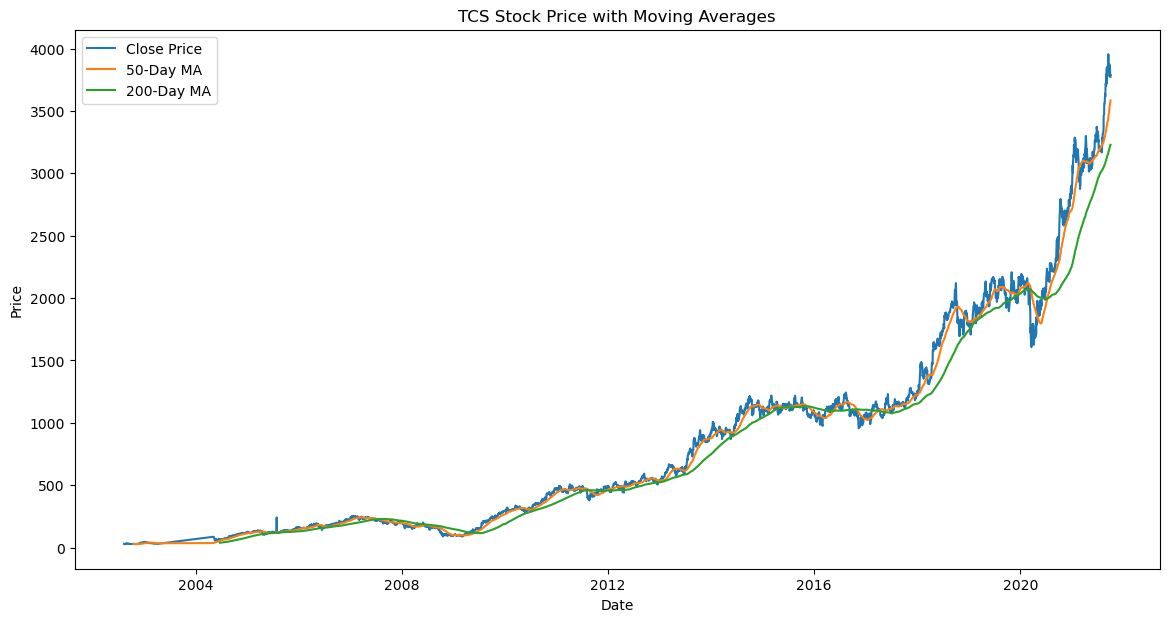

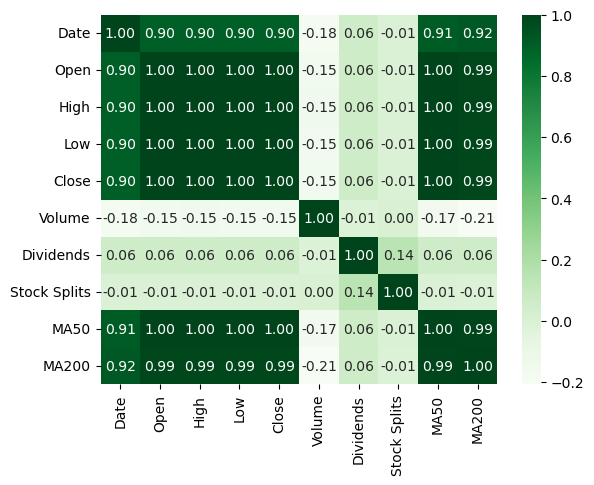

In [9]:
# Moving averages
df['MA50'] = df['Close'].rolling(window=50).mean()
df['MA200'] = df['Close'].rolling(window=200).mean()

plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Close'], label='Close Price')
plt.plot(df['Date'], df['MA50'], label='50-Day MA')
plt.plot(df['Date'], df['MA200'], label='200-Day MA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('TCS Stock Price with Moving Averages')
plt.legend()
plt.show()

# Correlation heatmap
sns.heatmap(df.corr(), annot=True, cmap='Greens', fmt='.2f')
plt.show()


In [3]:
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Day_of_Week'] = df['Date'].dt.dayofweek
df['Prev_Close'] = df['Close'].shift(1)
df.dropna(inplace=True)


NameError: name 'df' is not defined

In [ ]:
X = df[['Open', 'High', 'Low', 'Volume', 'Prev_Close', 'Day_of_Week', 'Month']]
y = df['Close']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R-Squared Score:", r2_score(y_test, y_pred))

plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, color='blue', label='Predicted vs Actual')
plt.xlabel('Actual Close Price')
plt.ylabel('Predicted Close Price')
plt.title('Actual vs Predicted Close Price')
plt.legend()
plt.show()


In [ ]:
with open('TCS_Stock_Predictor.pkl', 'wb') as file:
    pickle.dump(model, file)

In [ ]:
# Prepare data for LSTM
scaler = MinMaxScaler()
scaled_close = scaler.fit_transform(df['Close'].values.reshape(-1, 1))

X_lstm = scaled_close[:-1].reshape(-1, 1, 1)
y_lstm = scaled_close[1:]

model_lstm = Sequential()
model_lstm.add(LSTM(50, input_shape=(1, 1)))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

for epoch in tqdm(range(30)):
    for i in range(0, len(X_lstm), 15):
        model_lstm.train_on_batch(X_lstm[i:i+15], y_lstm[i:i+15])


In [1]:
# Predict on last 20% of data
test_ratio = 0.2
test_size = int(len(df) * test_ratio)
test_data = df[-test_size:]

X_test_lstm = scaler.transform(test_data['Close'].values.reshape(-1, 1)).reshape(-1, 1, 1)
lstm_predictions = model_lstm.predict(X_test_lstm).flatten()
lstm_predictions = scaler.inverse_transform(lstm_predictions.reshape(-1, 1))

plt.figure(figsize=(12, 6))
plt.plot(test_data['Date'], test_data['Close'], label='Actual Close Price', color='b')
plt.plot(test_data['Date'], lstm_predictions, label='Predicted Close Price (LSTM)', color='r')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs. Predicted Close Price using LSTM')
plt.legend()
plt.show()

mae = mean_absolute_error(test_data['Close'], lstm_predictions)
print("LSTM Mean Absolute Error:", mae)


NameError: name 'df' is not defined